In [9]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)
import utils
from scipy.stats import norm, t
from matplotlib.ticker import FormatStrFormatter
import MI

In [10]:
def line(ax,Ns,H,label,d=None,cut=None,color=None, linestyle='solid',alpha=0.2):
    if cut is None:
        cut = Ns.max()
    NN = cut+1-Ns.min()
    if d is None:
        d = np.zeros_like(H)
    A = np.empty((3,NN))
    for i in range(NN):
        n = Ns.min()+i
        A[0,i] = n
        if len(H[Ns==n])>0:
            A[1,i] = H[Ns==n].mean()
            A[2,i] = ((H[Ns==n].std())**2/len(H[Ns==n]) + (d[Ns==n].mean())**2)**0.5
        else:
            A[1:,i] = 0
    ax.plot(A[0],A[1],label=label,color=color, linestyle=linestyle)
    ax.fill_between(A[0],A[1]-A[2],A[1]+A[2],color='grey',alpha=alpha)

In [11]:
mrg=0.2
n_levels=8
Nvar=2

NSamp=10000
def sample_student(rhos,dfs):
    y = utils.student_rvs(Nvar,rhos,dfs,1).squeeze()
    y0 = np.zeros_like(y)
    for i in range(y.shape[0]):
        y0[i] = t.cdf(y[i],df=dfs[i])
    return y0

def sample_gauss(rhos,Nvar=2):
    samples=[]
    for rho in rhos:
        cov = np.ones(Nvar)*rho + (1-rho)*np.identity(Nvar)
        samples.append(np.random.multivariate_normal(np.zeros(Nvar),cov,(1,)).squeeze())
    return norm.cdf(np.array(samples))

def sample_complex(rhos,Nvar=2):
    y = sample_gauss(rhos,Nvar=Nvar)
    y += np.repeat(y.prod(axis=-1).reshape(NSamp,1),Nvar,axis=-1)**(1/Nvar) 
    transformed_y = (np.argsort(y.flatten()).argsort()/y.size).reshape(y.shape)
    return transformed_y
        

(5000, 10)


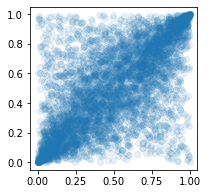

In [87]:
from utils import student_rvs #can be found here: https://github.com/NinelK/CopulaGP/blob/master/utils/student.py
from scipy.stats import t

def sample_student(Nvar,rhos,dfs):
    y = student_rvs(Nvar,rhos,dfs,1).squeeze()
    print(y.shape)
    y0 = np.zeros_like(y)
    for i in range(y.shape[0]):
        y0[i] = t.cdf(y[i],df=dfs[i])
    return y0

Nvar,NSamp = 10,5000
plt.figure(figsize=(3,3))
plt.scatter(*sample_student(Nvar,0.7*np.ones(NSamp),2.*np.ones(NSamp))[:,-2:].T,alpha=0.1)
# here, rho and df have a size of [NSamp], because I needed it for 'dynamic' models (where parameters change).

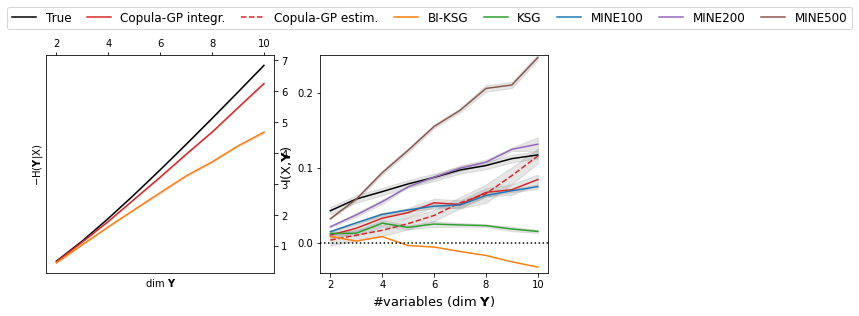

In [44]:
fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

def plot_student(Hrs,Hr):
    
    with open("StudentH.pkl",'rb') as f:
        results = pkl.load(f)
        
    Ns = np.array([res['Nvar'] for res in results])

    line(Hrs,Ns,np.array([res["true_HRgS"].mean() for res in results]),d = 0.005*np.ones(len(results)),
         label="True",cut=Ns.max(), color='k')
    line(Hrs,Ns,np.array([-res["eC"].mean() for res in results]),d = 0.005*np.ones(len(results)),
         label="Copula-GP",cut=Ns.max(), color='C3')
    line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),
         label="BI-KSG",cut=Ns.max(), color='C1')
    # line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")

    line(Hr,Ns,np.array([res["true_integral"][0] for res in results]),
         d = 0.005*np.ones(len(results)), label="True",cut=Ns.max(),color="black")
    line(Hr,Ns,np.array([res["integrated"] for res in results]), color='C3', 
         d = 0.005*np.ones(len(results)), label="Copula-GP integr.",cut=Ns.max())
    line(Hr,Ns,np.array([res["estimated"] for res in results]), color='C3', 
             d=np.array([0.005*np.sqrt(2) for res in results]), linestyle='dashed',
         label="Copula-GP estim.",cut=Ns.max())
    line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max(),color='C1',alpha=0)
#     line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max(),
#          color='C1',linestyle='dashed')
    line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max(),color='C2')
    line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max(), color='C0')
    line(Hr,Ns,np.array([res["MINE200"] for res in results]),label="MINE200",cut=Ns.max(),color='C4')
    line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max(),color='C5')

#     for a in [Hrs,Hr]:
#         a.set_xlabel("#variables (dim Y)")
#         a.yaxis.tick_right()
    Hr.set_xlabel("#variables (dim $\mathbf{Y}$)",fontsize=13)
    Hrs.set_xlabel("dim $\mathbf{Y}$")
    Hrs.yaxis.tick_right()
    Hrs.xaxis.tick_top()
#     Hrs.tick_params(axis="x",direction="in", pad=-15)
    Hrs.set_ylabel("$-$H($\mathbf{Y}$|X)",labelpad=1)
#     Hrs.tick_params(axis="y",direction="in", pad=-15)
    Hr.set_ylabel("I(X,$\mathbf{Y}$)",labelpad=3,fontsize=13)
    Hr.set_ylim(-0.04,0.25)
    Hr.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    Hr.set_yticks(np.arange(0.,0.201,0.1),minor=False)
    Hr.set_yticklabels([f"{i:.1f}" for i in np.arange(0.,0.201,0.1)])
#     Hr.tick_params(axis="y",direction="in", pad=-30)
    Hrs.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    Hr.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#     Hrs.legend(frameon=False);
    Hr.legend(bbox_to_anchor=(-1.37, 1.12, 3.7, .102), loc=3,
       ncol=8, mode="expand", borderaxespad=0., fontsize=12)
    Hr.axhline(0,color='k',linestyle='dotted')
    #legend(frameon=False,loc=(-4.,0.42), fontsize=7.3);
plot_student(Hrs,Hr)

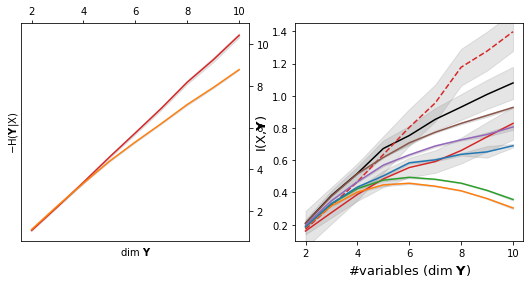

In [13]:
fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

def plot_complex(Hrs,Hr):

    with open("rtGaussH.pkl",'rb') as f:
        results = pkl.load(f)
    
    Ns = np.array([res['Nvar'] for res in results])

    line(Hrs,Ns,np.array([-res["eC"].mean() for res in results]),d = 0.01*Ns,
         label="CopulaGP",cut=Ns.max(),color='C3')
    line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),
         label="BI-KSG",cut=Ns.max(), color='C1')
    # line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")
    
    line(Hr,Ns,np.array([res["true_integral"] for res in results]),
         d = 0.01*Ns, label="True",cut=Ns.max(),color="black")
    line(Hr,Ns,np.array([res["integrated"] for res in results]), d = 0.01*Ns, 
         label="CopulaGP integr.",cut=Ns.max(),color='C3')
    line(Hr,Ns,np.array([res["estimated"] for res in results]), 
             d=np.array([(results[-1]['gauss_eU'].std()+0.01*Ns*np.sqrt(2)) for res in results]),
         label="CopulaGP estim.",cut=Ns.max(),color='C3',linestyle='dashed')
    line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max(),color='C1')
    line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max(),color='C2')
    line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max(),color='C0')
    line(Hr,Ns,np.array([res["MINE200"] for res in results]),label="MINE200",cut=Ns.max(),color='C4')
    line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max(),color='C5')

#     for a in [Hrs,Hr]:
#         a.set_xlabel("#variables (dim Y)")
    Hrs.yaxis.tick_right()
    Hr.set_xlabel("#variables (dim $\mathbf{Y}$)", fontsize=13)
    Hrs.set_xlabel("dim $\mathbf{Y}$")
    Hrs.yaxis.tick_right()
    Hrs.xaxis.tick_top()
    Hr.set_ylim(0.1,1.45)
#     Hrs.tick_params(axis="x",direction="in", pad=-15)
    Hrs.set_ylabel("$-$H($\mathbf{Y}$|X)",labelpad=0)
#     Hrs.tick_params(axis="y",direction="in", pad=-25)
    Hr.set_ylabel("I(X,$\mathbf{Y}$)",labelpad=3, fontsize=13)
#     Hr.tick_params(axis="y",direction="in", pad=-25)
#     Hrs.legend(frameon=False);
#     Hr.legend(frameon=True,loc=(1.02,0.17));
    Hrs.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    Hr.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plot_complex(Hrs,Hr)

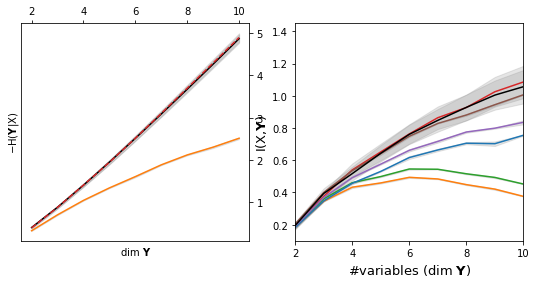

In [35]:
fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

def plot_gauss(Hrs,Hr):
    
    results_file = f"GaussH.pkl"
    with open(results_file,'rb') as f:
        results = pkl.load(f)  
        
    Ns = np.array([res['Nvar'] for res in results])

    line(Hrs,Ns,np.array([-res["eT"].mean() for res in results]),d = 0.01*Ns,
         label="True",cut=Ns.max(),color='k')
    line(Hrs,Ns,np.array([-res["eC"].mean() for res in results]),d = 0.01*Ns,
         label="CopulaGP",cut=Ns.max(),color='C3', linestyle='dashed')
    line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),
         label="BI-KSG",cut=Ns.max(),color='C1')
    # line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")

    line(Hr,Ns,np.array([res["integrated"] for res in results]), d = 0.01*Ns, 
         label="CopulaGP integrated",cut=Ns.max(),color='C3')
    line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max(), color='C1')
    line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max(), color='C2')
    line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max(), color='C0')
    line(Hr,Ns,np.array([res["MINE200"] for res in results]),label="MINE200",cut=Ns.max(),color='C4')
    line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max(),color='C5')

    line(Hr,Ns,np.array([res["true_integral"] for res in results]),
         d = 0.01*Ns, label="True",cut=Ns.max(),color="black")

#     for a in [Hrs,Hr]:
#         a.set_xlabel("#variables (dim Y)")
    Hr.set_xlabel("#variables (dim $\mathbf{Y}$)", fontsize=13)
    Hrs.set_xlabel("dim $\mathbf{Y}$")
    Hrs.yaxis.tick_right()
    Hrs.xaxis.tick_top()
    Hr.set_ylim(0.1,1.45)
    Hr.set_xlim(2,10)
#     Hrs.tick_params(axis="x",direction="in", pad=-15)
    Hrs.set_ylabel("$-$H($\mathbf{Y}$|X)",labelpad=0)
    Hr.set_ylabel("I(X,$\mathbf{Y}$)",labelpad=3, fontsize=13)
#     Hr.tick_params(axis="y",direction="in", pad=-25)
    Hrs.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    Hr.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#     Hrs.legend(frameon=False);
#    Hr.legend(frameon=False);
plot_gauss(Hrs,Hr)

In [57]:
results_file = f"rtGaussH.pkl"
with open(results_file,'rb') as f:
    results = pkl.load(f) 
for key in ['integrated','BI-KSG','KSG','MINE100','MINE500','estimated']:
    # mean OF (!) a ratio (not ratio of means)
    ratio = np.mean([res[key]/res['true_integral'] for res in results[-3:]]) # true[0] for student
    abs = np.mean([res[key]-res['true_integral'] for res in results[-3:]])
    print(key,abs,int(np.round(100*ratio)),'%') 

integrated -0.2533837954203288 76 %
BI-KSG -0.7282677536454326 31 %
KSG -0.6761223062509055 36 %
MINE100 -0.3582477163301694 66 %
MINE500 -0.13878463982888423 87 %
estimated 0.29987064997355145 128 %


/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


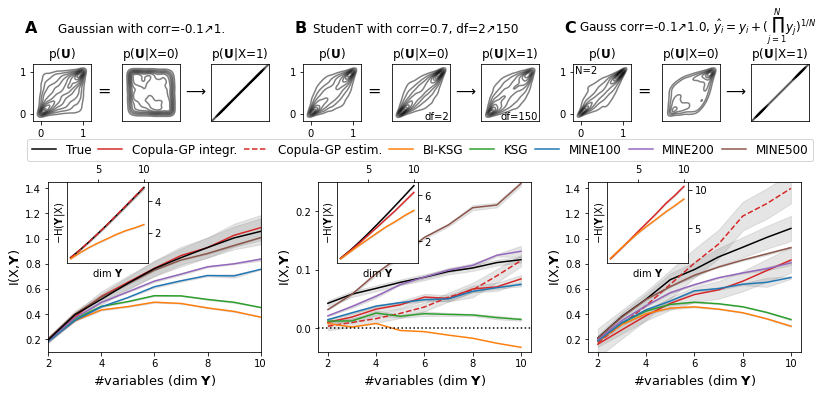

In [15]:
fig_width, fig_height = 11.25, 5.3
aspect = fig_width/fig_height
fig = plt.figure(figsize=(fig_width,fig_height))

l_mrg, b_mrg = 0.35/fig_width, aspect*0.5/fig_width
dens_size = 0.8/fig_width
dens_y = b_mrg + 3.2/fig_height
block_size = 2.95/fig_width
plot_width, plot_height = block_size, block_size*aspect
next_block = block_size+0.8/fig_width
plot_shift = .8*block_size+dens_size-plot_width 
plot_shift_n = plot_shift+0.023
nr = 0.38 #how much narrower the entropy plot is compared to MI plot
H_shift = plot_height * (0.8-nr)
# such that the right edge of the MI plot matches the last density plot

def plot_dataset(axes,data):
    
    (axA,ax0,ax1) = axes
    pos = axA.get_position()

    fig.text(pos.x0+0.28*pos.width*4,pos.y0+0.45*pos.height,'=',fontsize="16")
    fig.text(pos.x0+0.66*pos.width*4,pos.y0+0.45*pos.height,'⟶',fontsize="14")
    axA.set_title('p($\mathbf{U}$)')
    ax0.set_title('p($\mathbf{U}$|X=0)')
    ax1.set_title('p($\mathbf{U}$|X=1)')
    for ax in [ax0,ax1]:
        ax.set_xticks([], [])
        ax.set_yticks([], [])

    for ax,d in zip(axes,data):
        sns.kdeplot(*d.T, ax=ax, n_levels=n_levels,
                    cmap=None, colors='black', alpha=0.5, shade=False)

    axA.set_xticks([0,1])
    axA.set_yticks([0,1])
    axA.set_xticklabels([0,1])
    
# ax0 = fig.add_axes([0,0,1,1])

G_dA = fig.add_axes([l_mrg+0,dens_y,             dens_size,dens_size*aspect])
G_d0 = fig.add_axes([l_mrg+0.42*block_size,dens_y,dens_size,dens_size*aspect])
G_d1 = fig.add_axes([l_mrg+0.84*block_size,dens_y,dens_size,dens_size*aspect])
plot_dataset((G_dA,G_d0,G_d1),[sample_gauss(np.linspace(-0.1,1.,NSamp)),
                               sample_gauss(-0.1*np.ones(NSamp)),
                               sample_gauss(1.0*np.ones(NSamp))])

S_dA = fig.add_axes([l_mrg+next_block+0,dens_y,             dens_size,dens_size*aspect])
S_d0 = fig.add_axes([l_mrg+next_block+0.42*block_size,dens_y,dens_size,dens_size*aspect])
S_d1 = fig.add_axes([l_mrg+next_block+0.84*block_size,dens_y,dens_size,dens_size*aspect])
plot_dataset((S_dA,S_d0,S_d1),[sample_student(0.7*np.ones(NSamp),np.exp(5*np.linspace(0,1,NSamp))+1),
                               sample_student(0.7*np.ones(NSamp),2.*np.ones(NSamp)),
                               sample_student(0.7*np.ones(NSamp),150.*np.ones(NSamp))])
fig.text(l_mrg + next_block + 0.57*block_size,dens_y + 0.04*dens_size*aspect,'df=2',fontsize=10)
fig.text(l_mrg + next_block + 0.93*block_size,dens_y + 0.04*dens_size*aspect,'df=150',fontsize=10)

fig.text(l_mrg + 2*next_block+0.01*block_size,dens_y + 0.83*dens_size*aspect,'N=2')
H_dA = fig.add_axes([l_mrg+2*next_block+0,dens_y,             dens_size,dens_size*aspect])
H_d0 = fig.add_axes([l_mrg+2*next_block+0.42*block_size,dens_y,dens_size,dens_size*aspect])
H_d1 = fig.add_axes([l_mrg+2*next_block+0.84*block_size,dens_y,dens_size,dens_size*aspect])
plot_dataset((H_dA,H_d0,H_d1),[sample_complex(np.linspace(-0.1,1.,NSamp),Nvar=2)[:,[-2,-1]],
                            sample_complex(-0.1*np.ones(NSamp),Nvar=2)[:,[-2,-1]],
                            sample_complex(1.0*np.ones(NSamp),Nvar=2)[:,[-2,-1]]])

G_Hr  = fig.add_axes([l_mrg+plot_shift,b_mrg,plot_width,plot_height*0.8])
G_Hrs = fig.add_axes([l_mrg+plot_shift_n, b_mrg + H_shift,plot_width*nr,plot_height*nr])
fig.text(l_mrg-dens_size*0.15,dens_y+dens_size*aspect*1.55,"A",fontsize=16,fontweight='bold')
fig.text(l_mrg+dens_size*0.43,dens_y+dens_size*aspect*1.55,"Gaussian with corr=-0.1↗1.",fontsize=12)
plot_gauss(G_Hrs,G_Hr)

S_Hr  = fig.add_axes([l_mrg+next_block+plot_shift,b_mrg,plot_width,plot_height*0.8])
S_Hrs = fig.add_axes([l_mrg+next_block+plot_shift_n, b_mrg + H_shift,plot_width*nr,plot_height*nr])
fig.text(l_mrg+next_block-dens_size*0.15,dens_y+dens_size*aspect*1.55,"B",fontsize=16,fontweight='bold')
fig.text(l_mrg+next_block+dens_size*0.17,dens_y+dens_size*aspect*1.55,
         "StudenT with corr=0.7, df=2↗150",fontsize=12);
plot_student(S_Hrs,S_Hr)

H_Hr  = fig.add_axes([l_mrg+2*next_block+plot_shift,b_mrg,plot_width,plot_height*0.8])
H_Hrs = fig.add_axes([l_mrg+2*next_block+plot_shift_n, b_mrg + H_shift,plot_width*nr,plot_height*nr])
fig.text(l_mrg+2*next_block-dens_size*0.15,dens_y+dens_size*aspect*1.55,"C",fontsize=16,fontweight='bold')
fig.text(l_mrg+2*next_block+dens_size*0.1,dens_y+dens_size*aspect*1.55,
         "Gauss corr=-0.1↗1.0, $\hat{y}_i = y_i + (\prod_{j=1}^{N} y_j)^{1/N}$",fontsize=12);
plot_complex(H_Hrs,H_Hr)

In [127]:
fig.savefig("synthetic_result.pdf")

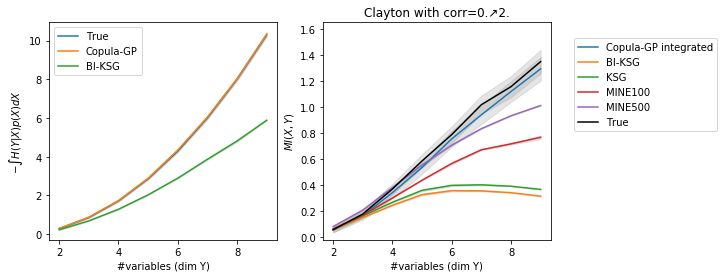

In [123]:
results_file = f"ClaytonH.pkl"
with open(results_file,'rb') as f:
    results = pkl.load(f)  
# results_file = f"ClaytonH_back.pkl"
# with open(results_file,'rb') as f:
#     results += pkl.load(f)   
Ns = np.array([res['Nvar'] for res in results])

fig, (Hrs,Hr) = plt.subplots(1,2,figsize=(9,4))

results[0]

line(Hrs,Ns,np.array([-res["eT"].mean() for res in results]),d = 0.01*Ns,label="True",cut=Ns.max())
line(Hrs,Ns,np.array([-res["eC"].mean() for res in results]),d = 0.01*Ns,label="Copula-GP",cut=Ns.max())
line(Hrs,Ns,np.array([-res["BI-KSG_H"] for res in results]),label="BI-KSG",cut=Ns.max())
# line(np.array([res[3][-1]/Ns/2 for res in results]),"KSG")

line(Hr,Ns,np.array([res["integrated"] for res in results]), d = 0.01*Ns, label="Copula-GP integrated",cut=Ns.max())
line(Hr,Ns,np.array([res["BI-KSG"] for res in results]),label="BI-KSG",cut=Ns.max())
line(Hr,Ns,np.array([res["KSG"] for res in results]),label="KSG",cut=Ns.max())
line(Hr,Ns,np.array([res["MINE100"] for res in results]),label="MINE100",cut=Ns.max())
line(Hr,Ns,np.array([res["MINE500"] for res in results]),label="MINE500",cut=Ns.max())

line(Hr,Ns,np.array([res["true_integral"] for res in results]),
     d = 0.01*Ns, label="True",cut=Ns.max(),color="black")

for a in [Hrs,Hr]:
    a.set_xlabel("#variables (dim Y)")
Hrs.set_ylabel("$-\int H(Y|X)p(X)dX$")
Hr.set_ylabel("$MI(X,Y)$")
Hr.set_title("Clayton with corr=0.↗2.")
Hr.set_ylim(-0.02,1.65)
Hrs.legend();
Hr.legend(loc=(1.1,0.5));